### 논문 인용 네트워크 분석  (Physics)

1. 총 논문 출판수, 분야별 출판수 파악

물리학 분야에 대해
1. 시드 설정 -> 2 사이클로 논문 수집
2. 인용수/피인용수로 논문 필터링 -> 인용 행렬 구축
3. 그래프 생성
4. 논문 메타 데이터 호출 -> 노드 속성으로 주입 + 중심성 계산
5. 새로운 합성 중심성 지표 설정
6. 클러스터링
7. 그래프 시각화 (외부 어플리케이션 Gephi 활용)
8. 브리지 중심성 지표 설정
9. 각 하위 분야별 성장 경향 파악 (X)
10. 커뮤니티간 평균 거리 계산 -> 커뮤니티 간 상호 연결성 시각화


In [ ]:
# 라이브러리 호출

import requests
import requests_cache
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import json
import pandas as pd
from tqdm import tqdm
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import networkx as nx
from collections import Counter
import community as community_louvain
import scipy.sparse as sp
import numpy as np
from scipy import sparse

In [9]:
# 0) API 기본 설정

# 같은 작업 재호출 시 API 요청 생략
# 캐시 + 세션 + 재시도
requests_cache.install_cache("openalex_cache", expire_after=7*24*3600)
session = requests_cache.CachedSession()

retry = Retry(
    total=3,
    backoff_factor=0.5,
    status_forcelist=[429,502,503,504],
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry)
session.mount("https://", adapter)

In [29]:
# 논문 발행 수 
def get_publication_counts(concept_id=None):
    base_url = "https://api.openalex.org/works"
    filters = [
        "from_publication_date:2000-01-01",
        "to_publication_date:2024-12-31",
        "type:article"  
    ]
    
    if concept_id:
        filters.append(f"concepts.id:{concept_id}")

    params = {
        "filter": ",".join(filters),
        "group_by": "publication_year",
        "per_page": 100
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    counts = {}
    for item in data["group_by"]:
        year = item["key"]
        count = item["count"]
        counts[year] = count

    return counts

def human_format(y, _):
    if y >= 1e6:
        return f'{y/1e6:.1f}M'
    elif y >= 1e3:
        return f'{y/1e3:.1f}K'
    else:
        return str(y)

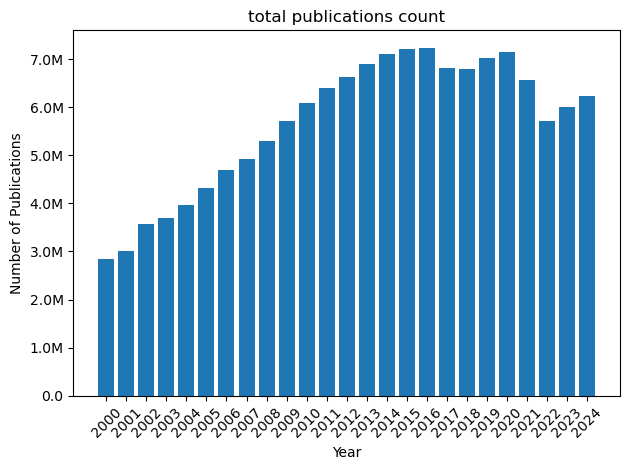

In [30]:
# 총 논문 발행 수
total_counts = get_publication_counts()
years = sorted(total_counts.keys())
counts = [total_counts[year] for year in years]

plt.figure()
plt.bar(years, counts)
plt.xticks(rotation=45)
plt.title("total publications count")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

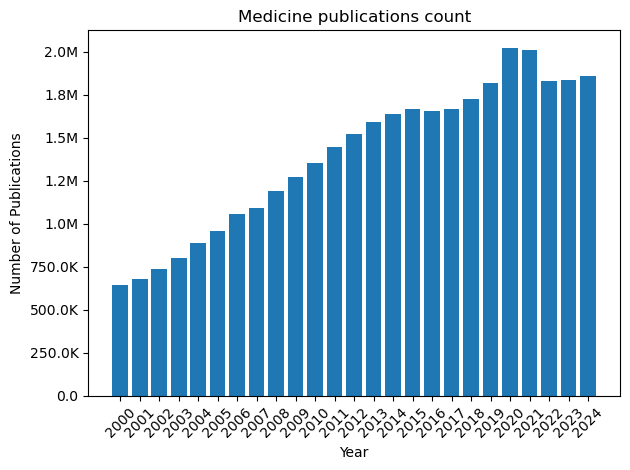

In [31]:
# Medicine 분야 논문 발행 수
md_counts = get_publication_counts("C71924100")
years = sorted(md_counts.keys())
counts = [md_counts[year] for year in years]

plt.figure()
plt.bar(years, counts)
plt.xticks(rotation=45)
plt.title("Medicine publications count")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

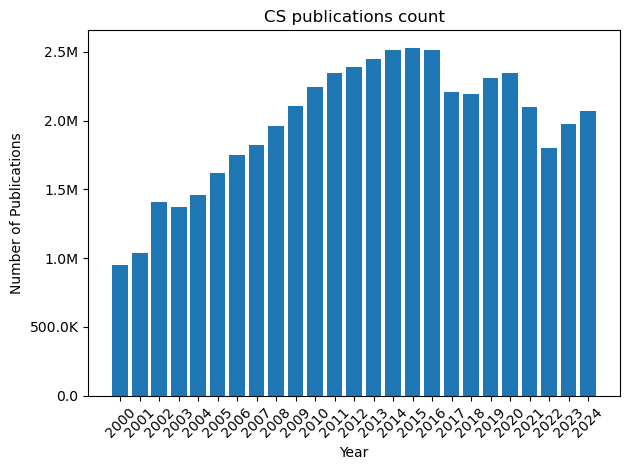

In [32]:
# Computer Science 분야 논문 발행 수
cs_counts = get_publication_counts("C41008148")
years = sorted(cs_counts.keys())
counts = [cs_counts[year] for year in years]

plt.figure()
plt.bar(years, counts)
plt.xticks(rotation=45)
plt.title("CS publications count")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

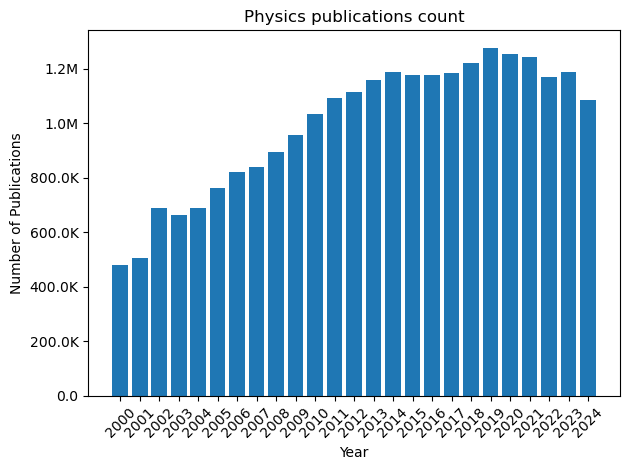

In [33]:
# Physics 분야 논문 발행 수
phy_counts = get_publication_counts("C121332964")
years = sorted(phy_counts.keys())
counts = [phy_counts[year] for year in years]

plt.figure()
plt.bar(years, counts)
plt.xticks(rotation=45)
plt.title("Physics publications count")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

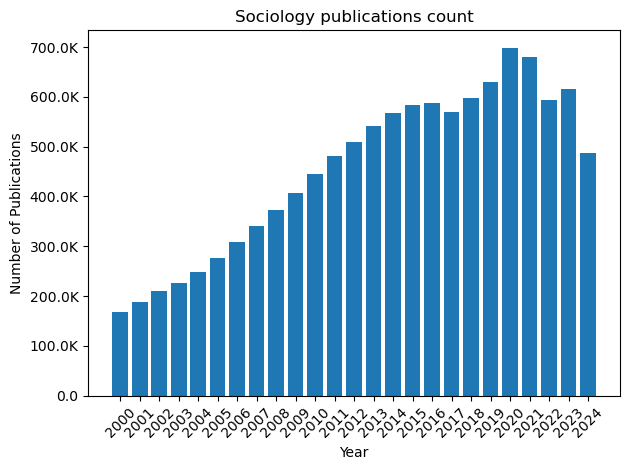

In [34]:
# Sociology 분야 논문 발행 수
sc_counts = get_publication_counts("C144024400")
years = sorted(sc_counts.keys())
counts = [sc_counts[year] for year in years]

plt.figure()
plt.bar(years, counts)
plt.xticks(rotation=45)
plt.title("Sociology publications count")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

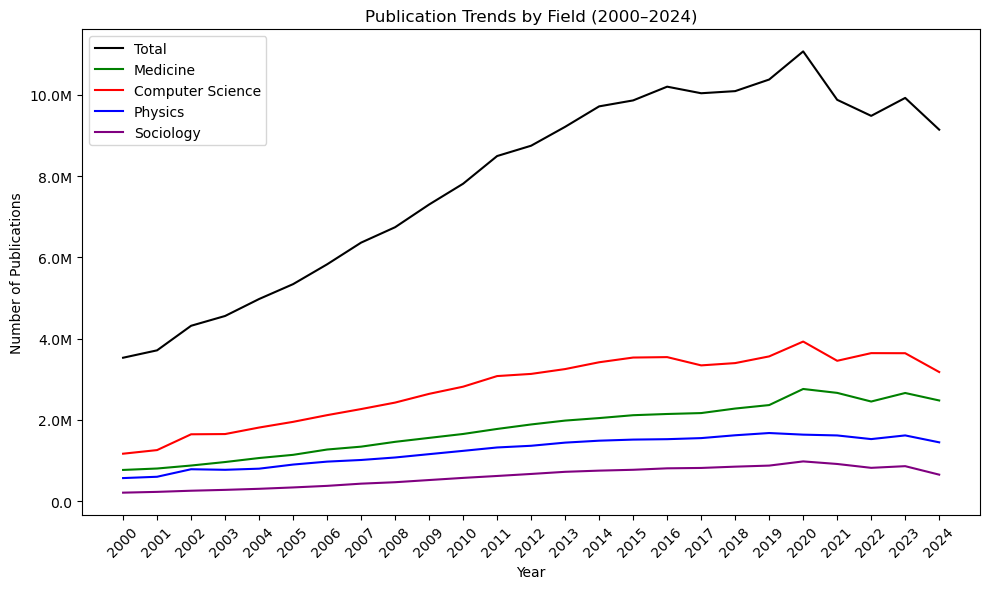

In [ ]:
years = sorted(total_counts.keys())

total_vals = [total_counts.get(year, 0) for year in years]
md_vals = [md_counts.get(year, 0) for year in years]
cs_vals = [cs_counts.get(year, 0) for year in years]
phy_vals = [phy_counts.get(year, 0) for year in years]
sc_vals = [sc_counts.get(year, 0) for year in years]

plt.figure(figsize=(10, 6))
plt.plot(years, total_vals, label="Total", color="black")
plt.plot(years, md_vals, label="Medicine", color="green")
plt.plot(years, cs_vals, label="Computer Science", color="red")
plt.plot(years, phy_vals, label="Physics", color="blue")
plt.plot(years, sc_vals, label="Sociology", color="purple")

plt.title("Publication Trends by Field (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.legend()
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.tight_layout()
plt.show()

In [ ]:
# seed 논문

base_url = "https://api.openalex.org/works"
seed_dois = ["https://doi.org/10.1063/1.4935926", # engineering
             "https://doi.org/10.1063/1.5006941", # material science
             "https://doi.org/10.1063/1.4858400", # physics and astronomy
             "https://doi.org/10.1063/1.5088164"] # computing science

# doi -> openalex 논문 id 변환 후 리스트로 저장
seed_id_list = []

for doi in seed_dois:
    name = doi.split("/")[-2] + "_" + doi.split("/")[-1]
    json_path = os.path.expanduser(f"./{name}.json")

    api_openalex = f"{base_url}/{doi}"
    resp = requests.get(api_openalex)
    data = resp.json()
    seed_id_list.append(data.get("id").split("/")[-1])
    if os.path.exists(json_path):
        print("already exist")

    else: 
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)  

    print("save json success")

print(seed_id_list)
print(name)

already exist
save json success
already exist
save json success
already exist
save json success
already exist
save json success
['W2192772080', 'W2783668429', 'W1975851231', 'W3100843411']
10.1063_1.5088164


In [7]:
# seed 기반으로 seed 논문을 인용한 논문들 추출
# type:article(논문), 최소 인용수 기준 필링
def edges_cited_by(id, min_cite = 0):
    cursor = "*"

    while cursor:
        params = {
            "filter": f"cites:{id},type:article,cited_by_count:>{min_cite}",
            "per_page":200,
            "cursor":cursor
        }
        data = session.get(base_url, params=params).json()
        results = data["results"]

        for result in results:
            citing_id = result["id"].split("/")[-1] 
            yield (citing_id, id)  

        cursor = data["meta"]["next_cursor"]
        if cursor is None:
            break

In [10]:
# 2) frontier 방식으로 2번의 cycle (edges_cited_by 함수 사용)

max_cycle = 2
MIN_CITE = 2
visited = set()
frontier = set(seed_id_list) 

id2idx = {}  # paper_id -> row/col number
row_idx = []  # 인용한 논문(citing) = row
col_idx = []  # 인용된 논문(cited) = col

# 논문 ID -> matrix index
def get_idx(paper_id):
    if paper_id not in id2idx:
        id2idx[paper_id] = len(id2idx)
    return id2idx[paper_id]

for cycle in range(1, max_cycle + 1):
    next_frontier = set()

    for pid in tqdm(frontier, total = len(frontier), 
                        desc=f"Cycle {cycle} seeds", unit="paper", leave=False):
        if pid in visited:
            continue
        visited.add(pid)

        # seed를 인용한 논문들 (cited_by)
        for src, tgt in edges_cited_by(pid, MIN_CITE):  # src(citing:인용) -> tgt(cited:피인용) 방향
            r = get_idx(src)  # row = citing
            c = get_idx(tgt)  # col = cited
            row_idx.append(r)
            col_idx.append(c)
            next_frontier.add(src)

    frontier = next_frontier
    tqdm.write(f"Cycle {cycle} -> new nodes : {len(next_frontier)}") 

N = len(id2idx)
data = np.ones(len(row_idx))
A_coo = sparse.coo_matrix((data, (row_idx, col_idx)), shape=(N, N))
A = A_coo.tocsr()

sparse.save_npz("adjacency.npz", A)                      

print(f"Nodes: {N:,} - adjacency.npz 저장 완료")

Cycle 1 -> new nodes : 4106


Cycle 2 -> new nodes : 47224
Nodes: 48,510 - adjacency.npz 저장 완료


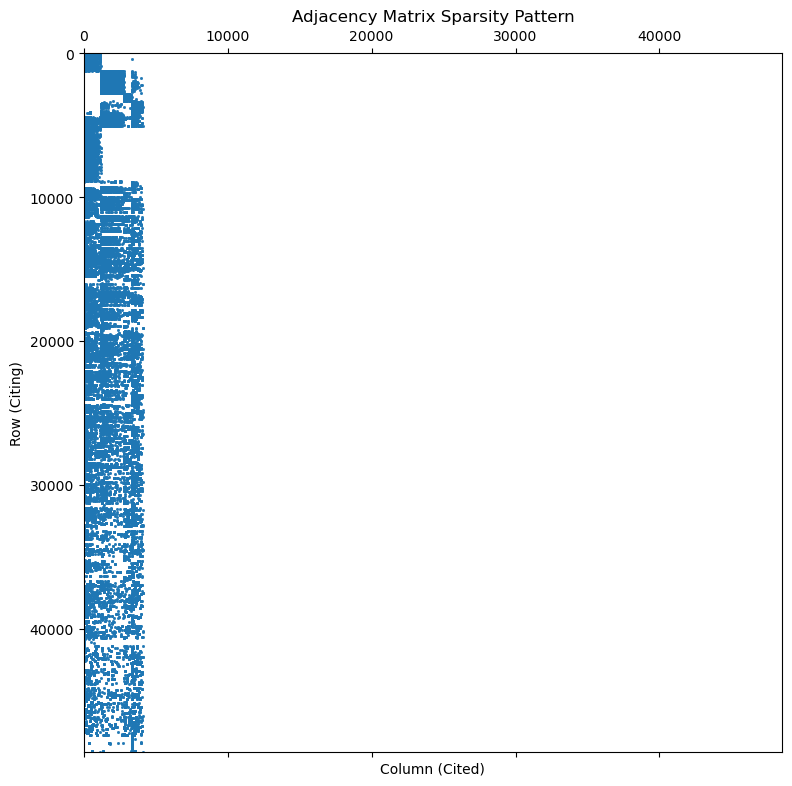

In [ ]:
# 희소 행렬 로드
A = sp.load_npz("adjacency.npz")

# 그래프 생성
plt.figure(figsize=(8, 8))
plt.spy(A, markersize=1)
plt.title("Adjacency Matrix Sparsity Pattern")
plt.xlabel("Column (Cited)")
plt.ylabel("Row (Citing)")
plt.tight_layout()
plt.show()

In [48]:
print(A[:, 1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1218 stored elements and shape (48510, 1)>
  Coords	Values
  (0, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  (25, 0)	1.0
  :	:
  (1194, 0)	1.0
  (1195, 0)	1.0
  (1196, 0)	1.0
  (1197, 0)	1.0
  (1198, 0)	1.0
  (1199, 0)	1.0
  (1200, 0)	1.0
  (1201, 0)	1.0
  (1202, 0)	1.0
  (1203, 0)	1.0
  (1204, 0)	1.0
  (1205, 0)	1.0
  (1206, 0)	1.0
  (1207, 0)	1.0
  (1208, 0)	1.0
  (1209, 0)	1.0
  (1210, 0)	1.0
  (1211, 0)	1.0
  (1212, 0)	1.0
  (1213, 0)	1.0
  (1214, 0)	1.0
  (1215, 0)	1.0
  (1216, 0)	1.0
  (1217, 0)	1.0
  (1218, 0)	1.0


In [11]:
A = sp.load_npz("adjacency.npz")

out_degree_vec = np.array(A.sum(axis=1)).flatten()  # out_degree = matrix 행의 합
in_degree_vec = np.array(A.sum(axis=0)).flatten()   # in_degree = matrix 열의 합

print(out_degree_vec)

# 조건: 인용/피인용 수 3미만 필터링
min_degree = 3
con = (in_degree_vec >= min_degree) & (out_degree_vec >= min_degree)

# 시드는 예외(시드 out_degree = 0 이므로) 
seed_idx = []
for pid in seed_id_list:
     seed_idx.append(id2idx[pid])

for idx in seed_idx:
     con[idx] = True


keep_indices = []
for idx, flag in enumerate(con):
    if flag==True:
        keep_indices.append(idx)

keep_indices = np.array(keep_indices)
N = out_degree_vec.shape[0]
N_new = keep_indices.shape[0]
print(keep_indices, N ,N_new)

# index 재설정: old_idx -> new_idx
old2new = {}
for new_idx, old_idx in enumerate(keep_indices):
    old2new[old_idx] = new_idx

# paper_id : new_idx mapping
id2idx_new = {}
for id, old_idx in id2idx.items():
    if con[old_idx] == True: 
            id2idx_new[id] = old2new[old_idx]

print(len(id2idx_new))

[1. 0. 2. ... 1. 1. 1.]
[   1    5    6 ... 3969 4081 4083] 48510 1463
1463


In [12]:
# 필터링된 행렬: A_filtered = A[keep_indices, :][:, keep_indices]
A = sp.load_npz("adjacency.npz")


A_filtered = A[keep_indices, :][:, keep_indices].tocsr()
print(A_filtered.shape, A_filtered.nnz)

sparse.save_npz("adjacency_filtered.npz", A_filtered)
print("adjacency_filtered.npz 저장 완료")

(1463, 1463) 6773
adjacency_filtered.npz 저장 완료


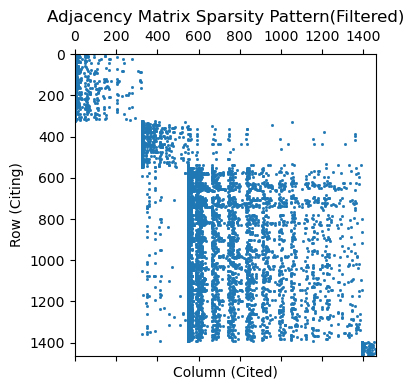

In [13]:
A_filtered = sp.load_npz("./adjacency_filtered.npz")

plt.figure(figsize=(4, 4))
plt.spy(A_filtered, markersize=1)
plt.title("Adjacency Matrix Sparsity Pattern(Filtered)")
plt.xlabel("Column (Cited)")
plt.ylabel("Row (Citing)")
plt.tight_layout()
plt.show()

In [52]:
print("A_filtered.shape =", A_filtered.shape)
print("len(id2idx_new) =", len(id2idx_new)) 

A_filtered.shape = (1463, 1463)
len(id2idx_new) = 1463


In [53]:
G = nx.DiGraph(A_filtered)

# idx -> paper_id mapping
idx2id = {v : k for k, v in id2idx_new.items()}
G = nx.relabel_nodes(G, idx2id)

In [54]:
# 노드들의 meta data
def fetch_meta(id_list, fields):
    chunk = "|".join(id_list)
    params = {"filter": f"ids.openalex:{chunk}", "select": fields,
              "per_page": len(id_list), "mailto": "nbalee00@khu.ac.kr"}
    try:
        data = session.get(base_url, params=params, timeout=10)
        data.raise_for_status()
        return data.json().get("results", [])
    except Exception as e:
        tqdm.write(f"batch 실패: {id_list[0][:6]}… → {e}")
        return []

In [ ]:
paper_ids = list(G.nodes())

fields = ",".join([
    "id",
    "doi",
    "display_name",
    "publication_year", 
    "primary_topic", 
    "primary_location",
    "authorships",
    "type"
])

CHUNK_SIZE = 100  # OpenAlex API 최대 per_page
meta = {}

batch_list = [paper_ids[i:i + CHUNK_SIZE] for i in range(0, len(paper_ids), CHUNK_SIZE)]

for batch in tqdm(batch_list, desc="Fetch Meta (serial)"):
    results = fetch_meta(batch, fields)
    for j in results:
        id = j["id"].split("/")[-1]
        meta[id] = {
            "doi": j.get("doi", ""),
            "title": j.get("display_name", ""),
            "year": j.get("publication_year", ""),
            "field": ((j.get("primary_topic") or {}).get("field") or {}).get("display_name", ""),
            "subfield": ((j.get("primary_topic") or {}).get("subfield") or {}).get("display_name", ""),
            "topic": (j.get("primary_topic") or {}).get("display_name", ""),
            "container_title": ((j.get("primary_location") or {}).get("source") or {}).get("display_name", ""),
            "publisher": ((j.get("primary_location") or {}).get("source") or {}).get("host_organization_name", ""),
            "authors": "; ".join(a["author"]["display_name"]
                                 for a in (j.get("authorships") or [])[:20]),
            "type": j.get("type", "")
        }
       
meta_df = pd.DataFrame.from_dict(meta, orient="index")
meta_df.to_csv("paper_metadata.csv", index=True, index_label="id",encoding='utf-8-sig')

Fetch Meta (parallel): 100%|██████████| 15/15 [00:00<00:00, 173.48it/s]


In [56]:
# meta data를 노드 속성으로 삽입
meta_df = pd.read_csv("./paper_metadata.csv", index_col="id")

for node in G.nodes():
    if node in meta_df.index:
        m = meta_df.loc[node]
        G.nodes[node]["title"] = m.get("title")
        G.nodes[node]["year"] = m.get("year", "")
        G.nodes[node]["authors"] = m.get("authors", "")
        G.nodes[node]["field"] = m.get("field", "")
        G.nodes[node]["subfield"] = m.get("subfield", "")
        G.nodes[node]["topic"] = m.get("topic", "")
        G.nodes[node]["container"] = m.get("container_title", "")
        G.nodes[node]["publisher"] = m.get("publisher", "")
        G.nodes[node]["doi"] = m.get("doi", "")
    else:
        G.nodes[node]["label"] = node

# 중심성 계산
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())
degree_dict = dict(G.degree())
pagerank_dict = nx.pagerank(G)
betweenness_dict = nx.betweenness_centrality(G)
eigenvector_dict = nx.eigenvector_centrality(G)

# 노드 속성으로 저장
for node in G.nodes():
    G.nodes[node]["in_degree"] = in_degree_dict.get(node, 0)
    G.nodes[node]["out_degree"] = out_degree_dict.get(node, 0)
    G.nodes[node]["degree"] = degree_dict.get(node, 0)
    G.nodes[node]["pagerank"] = pagerank_dict.get(node, 0)
    G.nodes[node]["betweenness"] = betweenness_dict.get(node, 0)
    G.nodes[node]["eigenvector"] = eigenvector_dict.get(node, 0)

# 노드 크기 설정 (pagerank 기준)
pr_values = list(pagerank_dict.values())
min_pr = min(pr_values)
max_pr = max(pr_values)
min_size = 5
max_size = 20

for node in G.nodes():
    pr = G.nodes[node]["pagerank"]
    size = ((pr - min_pr) / (max_pr - min_pr)) * (max_size - min_size) + min_size if max_pr > min_pr else min_size
    G.nodes[node]["size"] = size

In [57]:
# 클러스터링
clusters = community_louvain.best_partition(G.to_undirected())
nx.set_node_attributes(G, clusters, "cluster")
print(f"클러스터링 완료, 클러스터 수: {len(set(clusters.values()))}")

communities = {}
for pid, comm_id in clusters.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(pid)

# 각 커뮤니티의 크기(노드 수) 확인
for comm_id, nodes in communities.items():
    print(f"커뮤니티 {comm_id} 노드 수: {len(nodes)}")

클러스터링 완료, 클러스터 수: 10
커뮤니티 0 노드 수: 324
커뮤니티 1 노드 수: 206
커뮤니티 2 노드 수: 334
커뮤니티 3 노드 수: 74
커뮤니티 4 노드 수: 175
커뮤니티 5 노드 수: 46
커뮤니티 7 노드 수: 10
커뮤니티 8 노드 수: 11
커뮤니티 9 노드 수: 214
커뮤니티 6 노드 수: 69


In [58]:
# meta_df에 커뮤니티 번호, 중심성 추가
for node in G.nodes():
    meta_df.loc[node, "community"] = clusters[node]
    meta_df.loc[node, "in_degree"] = in_degree_dict.get(node),
    meta_df.loc[node, "out_degree"] = out_degree_dict.get(node),
    meta_df.loc[node, "degree"] = degree_dict.get(node),
    meta_df.loc[node, "eigenvector"] = eigenvector_dict.get(node),
    meta_df.loc[node, "pagerank"] = pagerank_dict.get(node),
    meta_df.loc[node, "betweenness"] = betweenness_dict.get(node),

meta_df.to_csv("paper_metadata.csv", index=True, index_label="id",encoding='utf-8-sig')

In [59]:
print(G.in_degree("W2192772080"))
df = pd.read_csv("filtered_paper_metadata.csv")
print(df.columns.tolist())

323
['id', 'doi', 'title', 'year', 'field', 'subfield', 'topic', 'container_title', 'publisher', 'authors', 'type', 'citation', 'bridging_centrality']


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# CSV 불러오기
df = pd.read_csv("paper_metadata.csv", index_col="id")

# 중심성 지표만 추출
centrality_cols = ['degree', 'in_degree', 'out_degree', 'eigenvector', 'pagerank', 'betweenness']
X = df[centrality_cols]

# 표준화 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 수행
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 5. 첫 번째 주성분 점수를 데이터프레임에 저장
df['PC1_score'] = X_pca[:, 0]

# 주성분 분산 비율 확인
explained_var = pca.explained_variance_ratio_
print(explained_var)
print(explained_var[0])

# 주성분 로딩값(기여도) 확인
loadings = pd.DataFrame(pca.components_.T,
                        index=centrality_cols,
                        columns=[f"PC{i+1}" for i in range(len(centrality_cols))])
print(loadings)

df.to_csv("paper_metadata.csv", index=True, index_label="id" ,encoding='utf-8-sig')

[6.28252099e-01 2.27418268e-01 1.11135812e-01 2.95666947e-02
 3.62712664e-03 7.01148253e-16]
0.6282520988100868
                  PC1       PC2       PC3       PC4       PC5           PC6
degree       0.506168  0.102969 -0.050619 -0.288694 -0.387416  7.051198e-01
in_degree    0.509087 -0.021179  0.072998 -0.294513 -0.401182 -6.981173e-01
out_degree   0.012124  0.703343 -0.697403  0.016425  0.055515 -1.242512e-01
eigenvector  0.473645 -0.107377 -0.083282  0.868935 -0.046341  3.837427e-15
pagerank     0.505367 -0.091873 -0.024229 -0.245315  0.821826  7.763982e-15
betweenness  0.068861  0.688685  0.705843  0.120088  0.091300  1.583172e-15


In [ ]:
print(clusters.items())

print(clusters.values())
print(clusters.keys())
print(clusters['W2905220617'])
cluster_counts = Counter(clusters.values())
print(cluster_counts)
print(cluster_counts.keys())
print(cluster_counts.values())
cluster_id = list(cluster_counts.keys())
print(cluster_id)

dict_items([('W2192772080', 0), ('W3082046560', 0), ('W2919666920', 0), ('W3129323667', 0), ('W2941420794', 0), ('W2593239660', 0), ('W2800220249', 0), ('W3155382531', 0), ('W3037178456', 0), ('W3193791902', 0), ('W2931028544', 0), ('W3184571572', 0), ('W3016774719', 0), ('W3136900496', 0), ('W2884957830', 0), ('W3031840420', 0), ('W2767097158', 0), ('W3116437754', 0), ('W2775285839', 0), ('W3039756950', 0), ('W4281485158', 0), ('W2988590925', 0), ('W4295300842', 0), ('W3005032699', 0), ('W4281566654', 0), ('W3128340416', 0), ('W3167530865', 0), ('W3184203295', 0), ('W4224661796', 0), ('W4387569457', 0), ('W4200343128', 0), ('W3124565101', 0), ('W3184236491', 0), ('W3165833274', 0), ('W3179950249', 0), ('W4210445970', 0), ('W4214731758', 0), ('W4288855725', 0), ('W4323670339', 0), ('W4214673811', 0), ('W4220719606', 0), ('W4391781690', 0), ('W4384830651', 0), ('W4385363097', 0), ('W4366526184', 0), ('W4391361422', 0), ('W2887350181', 0), ('W2891043551', 0), ('W3023293379', 0), ('W30415

In [62]:
# 클러스터별 노드 수 집계 및 대표 노드 추출
cluster_counts = Counter(clusters.values())

cluster_stats = pd.DataFrame({
    "cluster": list(cluster_counts.keys()),
    "num_nodes": list(cluster_counts.values())
})

cluster_stats.to_csv("cluster_node_counts.csv", index=False)
print("Node counts per cluster saved → cluster_node_counts.csv")

clusters_id = cluster_stats["cluster"].tolist()

top5_nodes = []

for cid in clusters_id:
    nodes = []
    for paper_id, cluster_id in clusters.items():
        if cluster_id == cid:
            nodes.append(paper_id)

    nodes_sorted = sorted(nodes, key=lambda paper_id: df.loc[paper_id, "PC1_score"], reverse=True)  
    
    for paper_id in nodes_sorted[:5]:
        top5_nodes.append({
        "cluster": cid,
        "paper_id": paper_id,
        "title": G.nodes[paper_id].get("title", ""),
        "year": G.nodes[paper_id].get("year"),
        "field": G.nodes[paper_id].get("field"),
        "subfield": G.nodes[paper_id].get("subfield"),
        "topic": G.nodes[paper_id].get("topic"),
        "pagerank": G.nodes[paper_id].get("pagerank", 0),
        "PC1_score": df.loc[paper_id, "PC1_score"]
    })

pd.DataFrame(top5_nodes).to_csv("cluster_top5_nodes.csv", index=False)
print("Representative nodes per cluster saved → cluster_top5_nodes.csv")

Node counts per cluster saved → cluster_node_counts.csv
Representative nodes per cluster saved → cluster_top5_nodes.csv


In [ ]:
# 그래프 저장(graphwrite_graphml 포맷 -> gephi)

nx.write_graphml(G, "filtered_physics_paper.graphml", encoding="utf-8")
print("graphml 저장 완료 → filtered_physics_paper.graphml") 

graphml 저장 완료 → filtered_physics_paper.graphml


In [ ]:
# Bridging Coefficient 계산
# 논문 i의 BC_i = 1 / sum(자신과 이웃 노드를 제외한 다른 노드들과의 최단거리)
shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
bridging_coeff = {}

for node in G.nodes():
    neighbors = set(G.neighbors(node)) | {node}  # 자기 자신과 이웃 노드
    total_dist = 0

    for other_node in G.nodes():
        if other_node in neighbors:  # 자기 자신과 이웃 노드는 제외
            continue

        try: 
            dist = shortest_paths[node][other_node]
            total_dist += dist
        except KeyError:
            continue
    
    if total_dist > 0:
        bridging_coeff[node] = 1 / total_dist
    else:
        bridging_coeff[node] = 0

# 4) Bridging Centrality = BC * Betweenness
df = pd.read_csv("paper_metadata.csv", index_col="id")

for node in G.nodes():
    bc = bridging_coeff[node]
    btw = betweenness_dict.get(node, 0.0)
    df.loc[node, "bridging_centrality"] = bc * btw

df.to_csv("filtered_paper_metadata.csv", index=True, index_label="id" ,encoding='utf-8-sig')


In [ ]:
comm_ids = sorted(communities.keys())
inter_conn = pd.DataFrame(index=comm_ids, columns=comm_ids, data=0.0)

for i in comm_ids:
    for j in comm_ids:
        if i == j:
            continue
        count = 0
        for u in communities[i]:
            for v in communities[j]:
                if G.has_edge(u, v):
                    count += 1
        possible = len(communities[i]) * len(communities[j])
        inter_conn.loc[i, j] = count / possible if possible > 0 else 0.0

In [66]:
# 커뮤니티 성장 분석
meta_df = pd.read_csv("paper_metadata.csv")

data = meta_df[["community", "year", "in_degree"]]

grouped = data.groupby(["community", "year"])

result = []
for (comm, year), group in grouped:
    publications = len(group)
    citations = group["in_degree"].sum()
    result.append({
        "community": comm,
        "year": year,
        "publication": publications,
        "citation": citations
    })

growth_df = pd.DataFrame(result)
print(growth_df.head())

   community  year  publication  citation
0        0.0  2015            1     323.0
1        0.0  2017            4      35.0
2        0.0  2018           11      31.0
3        0.0  2019           34     111.0
4        0.0  2020           69      98.0


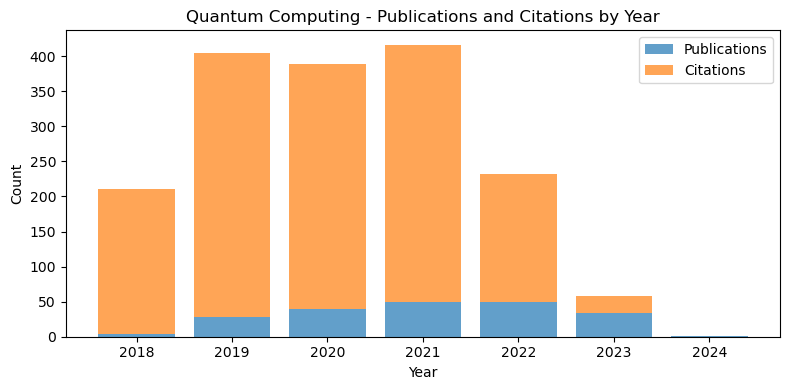

In [67]:
subset1 = growth_df[growth_df["community"] == 1]

plt.figure(figsize=(8, 4))
plt.bar(subset1["year"], subset1["publication"], label="Publications", alpha=0.7)
plt.bar(subset1["year"], subset1["citation"], label="Citations", alpha=0.7, bottom=subset1["publication"])

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"Quantum Computing - Publications and Citations by Year")
plt.legend()
plt.tight_layout()
plt.show()

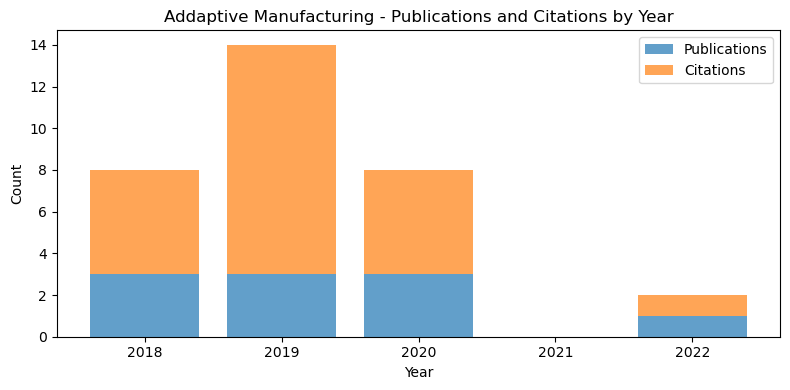

In [68]:
subset7 = growth_df[growth_df["community"] == 7]

plt.figure(figsize=(8, 4))
plt.bar(subset7["year"], subset7["publication"], label="Publications", alpha=0.7)
plt.bar(subset7["year"], subset7["citation"], label="Citations", alpha=0.7, bottom=subset7["publication"])

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"Addaptive Manufacturing - Publications and Citations by Year")
plt.legend()
plt.tight_layout()
plt.show()

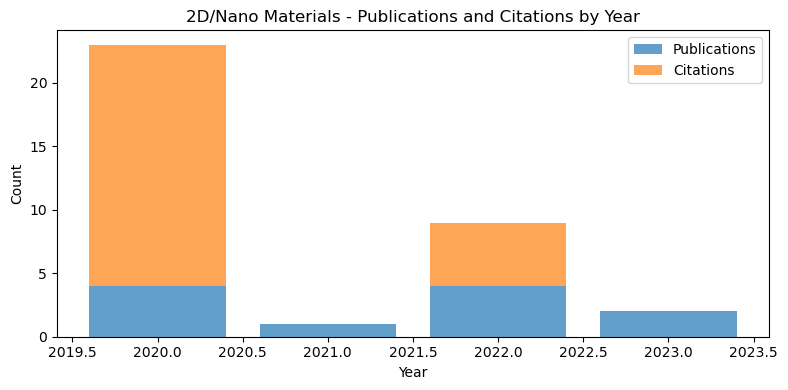

In [69]:
subset8 = growth_df[growth_df["community"] == 8]

plt.figure(figsize=(8, 4))
plt.bar(subset8["year"], subset8["publication"], label="Publications", alpha=0.7)
plt.bar(subset8["year"], subset8["citation"], label="Citations", alpha=0.7, bottom=subset8["publication"])

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"2D/Nano Materials - Publications and Citations by Year")
plt.legend()
plt.tight_layout()
plt.show()

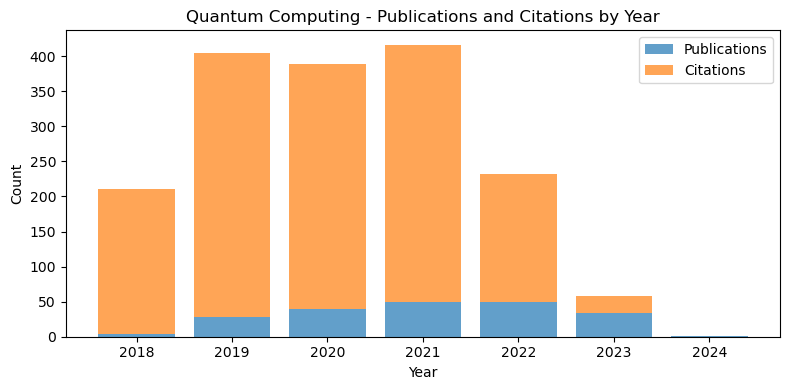

In [70]:
subset1 = growth_df[growth_df["community"] == 1]

plt.figure(figsize=(8, 4))
plt.bar(subset1["year"], subset1["publication"], label="Publications", alpha=0.7)
plt.bar(subset1["year"], subset1["citation"], label="Citations", alpha=0.7, bottom=subset1["publication"])

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"Quantum Computing - Publications and Citations by Year")
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
print(set(clusters.values()))

comm_index = {c: i for i, c in enumerate(communities)}
print(comm_index)

print(len(communities))

for n in G.nodes:
    if G.nodes[n].get("cluster") == c1:
        nodes_c1 = n

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
10


/opt/anaconda3/envs/graphenv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


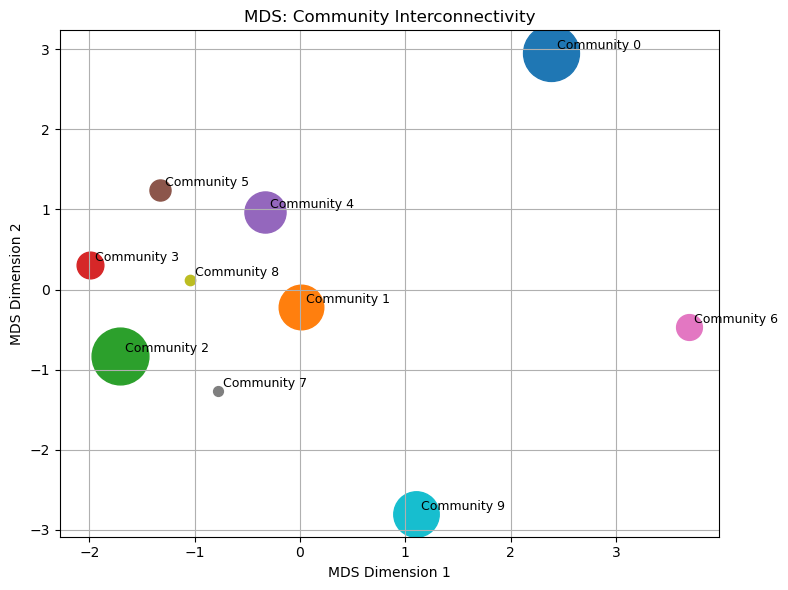

In [ ]:
from sklearn.manifold import MDS

# 그래프 로드 및 커뮤니티 정보 추출
communities = list(set(clusters.values()))
num_comms = len(communities)

# 커뮤니티 간 평균 최단 거리 계산
shortest_paths = dict(nx.all_pairs_shortest_path_length(G.to_undirected()))
distance_matrix = np.zeros((num_comms, num_comms))

for c1 in communities:
    for c2 in communities:
        if c1 == c2:
            continue
        dists = []
        nodes_c1 = []
        for n in G.nodes:
            cluster = G.nodes[n].get("cluster")  # 노드 n의 커뮤니티 번호 가져오기
            if cluster == c1:
                nodes_c1.append(n)  # 일치하면 리스트에 추가

        nodes_c2 = []
        for n in G.nodes:
            cluster = G.nodes[n].get("cluster")  # 노드 n의 커뮤니티 번호 가져오기
            if cluster == c2:
                nodes_c2.append(n)

        for n1 in nodes_c1:
            for n2 in nodes_c2:
                try:
                    dists.append(shortest_paths[n1][n2])
                except KeyError:
                    continue
        if dists:
            distance_matrix[communities[c1], communities[c2]] = np.mean(dists)
        else:
            distance_matrix[communities[c1], communities[c2]] = np.inf  # 연결 안 된 경우

# inf → 최대 거리보다 큰 값으로 대체
max_dist = np.nanmax(distance_matrix[distance_matrix != np.inf])
distance_matrix[distance_matrix == np.inf] = max_dist * 1.2

# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

community_sizes = {}
for c in communities:
    count = 0 
    for n in G.nodes:
        cluster = G.nodes[n].get("cluster") 
        if cluster == c:  
            count += 1    
    
    community_sizes[c] = count

# 시각화
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(coords):
    size = community_sizes[communities[i]] * 5
    plt.scatter(x, y, s=size)
    plt.text(x + 0.05, y + 0.05, f"Community {communities[i]}", fontsize=9)
plt.title("MDS: Community Interconnectivity")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()